# The Deutsch–Jozsa algorithm

<div class="alert alert-info">
    This notebook is no longer being maintained and we cannot guarantee that it will run
</div>

The Deutsch-Josza algorithm is an algorithm that deterministically solves the following problem:

Given an [oracle](https://dojo.qulacs.org/en/latest/notebooks/8.1_oracle.html) that implements the function

$$
    \begin{equation}
        f: \{0, 1\}^n \rightarrow \{0, 1\}
    \end{equation}
$$

where $\{0, 1\}^n$ is a bit string of length $n$ and the function is guaranteed to be either constant (maps all possible bit strings to either 0 or 1<a name="cite_ref-1"></a>[<sup>[1]</sup>](#cite_note-1)) or balanced (map half of the bit strings to 0 and the other half to 1.) 

In this example, we demostrate how to use QURI Parts to:

- Build the problem oracle
- Embed the oracle into the solution circuit
- Execute the solution circuit

<a name="cite_note-1"></a>[1] [^](#cite_ref-1) In the case of constant function, the algorithm works for oracle that implements $f(x) = 0$ and $f(x) = 1$. However, without loss of generality, we only build the oracle such that it implements $f(x) = 0$ in the case of constant function.

## The problem oracle

In this section, we build the oracle circuit with QURI Parts. If the oracle implements a constant function, we simply return a function with no gates. If the oracle implements a balanced function, we randomly pick $2^{n-1}$ bit strings out of $2^n$ possible input bit strings that satisfies $f(x) = 1$.

For bit strings of lenth $n$, the oracle is implemented as a circuit with $n+1$ qubits. The first $n$ qubits represent the input bit string and the last qubit represents the output. Thus, the oracles are implemented as several multi-controlled X gates where the first $n$ qubits are control qubits controlled on those bit strings that makes the function $f$ output 1. For example, if $f(0010) = 1$, we add a multi-controlled X gate to the circuit where the first 4 qubits are control indices with control values 0, 1, 0, 0.

In [ ]:
from numpy.random import choice
from quri_parts.circuit import QuantumCircuit


def get_dj_oracle(n_bit_length: int, balanced: bool) -> QuantumCircuit:
    n_qubits = n_bit_length + 1
    if not balanced:
        return QuantumCircuit(n_qubits)
    
    flipped = choice(2**n_bit_length, size=2**(n_bit_length-1), replace=False)
    circuit = QuantumCircuit(n_qubits)
    
    for f in flipped:
        controlled_on = {i: (f >> i) & 1 for i in range(n_bit_length)}
        circuit.add_X_gate(n_qubits-1, controlled_on)
    
    return circuit


Here, we show the circuit

In [ ]:
from quri_parts.circuit.utils.circuit_drawer import draw_circuit
draw_circuit(get_dj_oracle(n_bit_length=4, balanced=True))

                                                                  
                                                                  
0 ----●-------○-------○-------○-------●-------○-------○-------●---
      |       |       |       |       |       |       |       |   
      |       |       |       |       |       |       |       |   
      |       |       |       |       |       |       |       |   
1 ----●-------○-------●-------●-------●-------●-------●-------○---
      |       |       |       |       |       |       |       |   
      |       |       |       |       |       |       |       |   
      |       |       |       |       |       |       |       |   
2 ----○-------○-------○-------●-------●-------○-------●-------●---
      |       |       |       |       |       |       |       |   
      |       |       |       |       |       |       |       |   
      |       |       |       |       |       |       |       |   
3 ----○-------●-------●-------○-------●-------○-------●-------

Let's confirm that the circuit does implement the correct oracle

In [ ]:
from quri_parts.core.state import ComputationalBasisState
from quri_parts.qulacs.simulator import evaluate_state_to_vector
import numpy as np
import pandas as pd

bit_length = 4
n_qubit = bit_length + 1
oracle = get_dj_oracle(bit_length, True)
function_output_dict = {}

for i in range(2**bit_length):
    out_vector = evaluate_state_to_vector(
        ComputationalBasisState(n_qubit, bits=i).with_gates_applied(oracle)
        ).vector
    res = np.where(out_vector == 1)[0][0] >> bit_length
    function_output_dict[bin(i)[2:].zfill(bit_length)] = res


print(
    pd.DataFrame.from_dict(
        function_output_dict, orient="index", columns=["function output"]
    ).reset_index().rename(columns={"index": "function input"}).sort_values(
        "function output"
    ).reset_index(drop=True).T.to_markdown()
)

|                 |    0 |    1 |    2 |    3 |    4 |    5 |    6 |    7 |    8 |    9 |   10 |   11 |   12 |   13 |   14 |   15 |
|:----------------|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|
| function input  | 0000 | 0100 | 0101 | 0110 | 0111 | 1000 | 1011 | 1111 | 0001 | 0010 | 0011 | 1001 | 1010 | 1100 | 1101 | 1110 |
| function output |    0 |    0 |    0 |    0 |    0 |    0 |    0 |    0 |    1 |    1 |    1 |    1 |    1 |    1 |    1 |    1 |


We can see here that the oracle indeed implements a balanced function.

## The algorithm

Now, we implement the Deutsch-Jozsa algorithm that determines whether the function is balanced or not. The circuit is given by the below figure.

![png](dj_algorithm_circuit.png)

In [ ]:
def get_algorithm_circuit(oracle: QuantumCircuit) -> QuantumCircuit:
    n_qubits = oracle.qubit_count
    n_func_arg = oracle.qubit_count - 1
    circuit = QuantumCircuit(n_qubits, n_func_arg)
    
    circuit.add_X_gate(n_qubits-1)
    for i in range(n_qubits):
        circuit.add_H_gate(i)
    circuit.extend(oracle)
    for i in range(n_func_arg):
        circuit.add_H_gate(i)

    return circuit

As an example, we demonstrate an oracle of 4 qubits embedded inside the solution algorithm

In [ ]:
oracle = get_dj_oracle(3, True)
algorithm = get_algorithm_circuit(oracle)
draw_circuit(algorithm)

     ___                                             ___  
    | H |                                           | H | 
0 --|1  |-------------○-------●-------●-------●-----|9  |-
    |___|             |       |       |       |     |___| 
     ___              |       |       |       |      ___  
    | H |             |       |       |       |     | H | 
1 --|2  |-------------●-------●-------○-------●-----|10 |-
    |___|             |       |       |       |     |___| 
     ___              |       |       |       |      ___  
    | H |             |       |       |       |     | H | 
2 --|3  |-------------●-------○-------●-------●-----|11 |-
    |___|             |       |       |       |     |___| 
     ___     ___     _|_     _|_     _|_     _|_          
    | X |   | H |   | X |   | X |   | X |   | X |         
3 --|0  |---|4  |---|5  |---|6  |---|7  |---|8  |---------
    |___|   |___|   |___|   |___|   |___|   |___|         


Finally, we run the algorithm with a sampler. The algorithm is deterministic, so one shot is enough to determine if the function is balanced or not.

In [ ]:
from quri_parts.qulacs.sampler import create_qulacs_vector_sampler
from quri_parts.core.utils.recording import Recorder, recordable
from collections import Counter

@recordable
def run_algorithm(recorder: Recorder, oracle: QuantumCircuit, n_shots: int=1) -> bool:
    """If function is balanced return 1. Otherwise return 0
    """
    algorithm = get_algorithm_circuit(oracle)
    sampler = create_qulacs_vector_sampler()
    sampling_count = sampler(algorithm, n_shots)
    
    # pick out the measurement result from the first n qubits.
    fnc_arg_cnt = Counter()
    filter_str = 2**(oracle.qubit_count-1) - 1
    for qubit, cnt in sampling_count.items():
        fnc_arg_cnt += Counter({qubit & filter_str: cnt})

    recorder.info("sampling count", fnc_arg_cnt)

    is_balanced = 0 not in fnc_arg_cnt
    return is_balanced

We first run the algorithm with an oracle that implements a constant function.

In the Deutsch-Jozsa algorithm, the measured outcome of the first $n$ qubits should all be zero.

is balanced: False


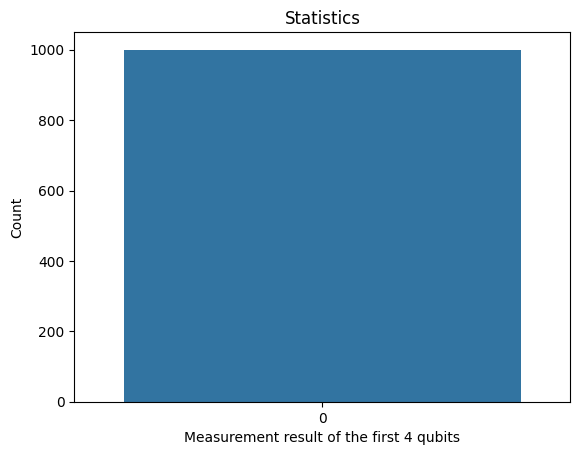

In [ ]:
from quri_parts.core.utils.recording import INFO, RecordSession
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

session_constant = RecordSession()
session_constant.set_level(INFO, run_algorithm)

with session_constant.start():
    oracle = get_dj_oracle(4, balanced=False)
    print("is balanced:", run_algorithm(oracle, 1000))

constant_group, = session_constant.get_records().get_history(run_algorithm)

ax = sns.barplot(
    pd.DataFrame.from_dict(
        constant_group.entries[0].data[1], orient='index', columns=["count"]
    ).T
)
ax.set(
    xlabel = "Measurement result of the first 4 qubits",
    ylabel = "Count",
    title = "Statistics"
)
plt.show()

Finally, we run the algorithm with an oracle that implements a balanced function.

is balanced: True


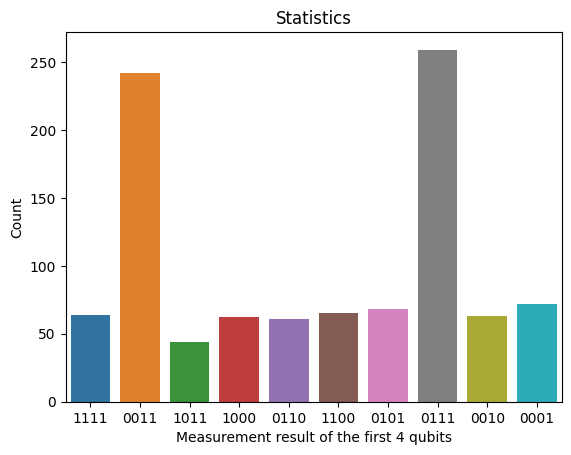

In [ ]:
session_balanced = RecordSession()
session_balanced.set_level(INFO, run_algorithm)

with session_balanced.start():
    oracle = get_dj_oracle(4, balanced=True)
    print("is balanced:", run_algorithm(oracle, 1000))

balanced_group, = session_balanced.get_records().get_history(run_algorithm)

table = pd.DataFrame.from_dict(
    balanced_group.entries[0].data[1], orient='index', columns=["count"]
).T
table.columns = list(map(lambda x: bin(x)[2:].zfill(4), table.columns))
ax = sns.barplot(table)
ax.set(
    xlabel = "Measurement result of the first 4 qubits",
    ylabel = "Count",
    title = "Statistics"
)
plt.show()